In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm
import torch
import torch.nn as nn
from sklearn.manifold import TSNE
import umap
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_stock_data(ticker, start_date, end_date):
    data = yf.download(tickers=[ticker], start=start_date, end=end_date, interval="1d")
    data['Pct Change'] = data['Close'].pct_change() * 100
    data = data.dropna()
    data.drop(columns=['High', 'Low', 'Adj Close'], inplace =True)
    data.reset_index(inplace=True)
    
    # plt.figure()
    # plt.plot(data['Date'], data['Close'])
    # plt.title(f"Daily {ticker} Price", fontsize=16)
    # plt.xlabel('Date', fontsize=14)
    # plt.ylabel('Price', fontsize=14)
    # plt.grid(True)
    # plt.show()

    # plt.figure()
    # plt.plot(data['Date'], data['Pct Change'])
    # plt.title(f"Daily {ticker} Percentage Change", fontsize=16)
    # plt.xlabel('Date', fontsize=14)
    # plt.ylabel('Percentage Change', fontsize=14)
    # plt.grid(True)
    # plt.show()
    return data

def get_index(data, date):
    return data[data['Date'] == date].index[0]

def sliding_window(x, window_size):
    out = np.empty((0, window_size))
    for i in range(len(x)-window_size+1):
        out = np.vstack((out, x[i:i+window_size]))
    return out

def plot_autocorr(data, lag):
    fig, ax = plt.subplots()
    plot_acf(data, lags=lag, zero=False, ax=ax)
    ax.set_ylim(-0.2, 0.2)
    return

def construct_price_from_pct(pct_array, initial_value):
    price = np.zeros(len(pct_array)+1)
    price[0] = initial_value
    for i in range(1, len(pct_array)+1):
        price[i] = price[i-1]*(1+pct_array[i-1]/100)
    return price

def get_pct1d(arr):
    percentage_change = np.zeros(len(arr))
    for i in range(1, len(arr)):
        if arr[i-1] != 0:
            percentage_change[i] = (arr[i] - arr[i-1]) / arr[i-1] * 100
        else:
            percentage_change[i] = 0
    return percentage_change[1:]

def get_pct2d(matrix):
    rows, cols = matrix.shape
    percentage_matrix = np.zeros((rows, cols - 1))
    for i in range(rows):
        for j in range(1, cols):
            if matrix[i, j-1] != 0:
                percentage_matrix[i, j-1] = (matrix[i, j] - matrix[i, j-1]) / matrix[i, j-1] * 100
            else:
                percentage_matrix[i, j-1] = 0
    return percentage_matrix

def plot_tsne(real_samples, generated_samples):
    tsne = TSNE(n_components=2)
    generated_samples = generated_samples.detach()
    all_data = np.concatenate([real_samples, generated_samples], axis=0)
    embedding = tsne.fit_transform(all_data)
    plt.figure()
    plt.title("T-SNE Plot")
    plt.scatter(embedding[:len(real_samples), 0], embedding[:len(real_samples), 1], label="Real", alpha=0.5)
    plt.scatter(embedding[len(real_samples) :, 0], embedding[len(real_samples) :, 1], label="Generated", alpha=0.5)
    plt.legend()

def plot_umap(real_samples, generated_samples):
    reducer = umap.UMAP()
    generated_samples = generated_samples.detach()
    all_data = np.concatenate([real_samples, generated_samples], axis=0)
    embedding = reducer.fit_transform(all_data)
    plt.figure()
    plt.title("UMAP Plot")
    plt.scatter(embedding[:len(real_samples), 0], embedding[:len(real_samples), 1], label="Original", alpha=0.5)
    plt.scatter(embedding[len(real_samples) :, 0], embedding[len(real_samples) :, 1], label="Generated", alpha=0.5)
    plt.legend()
    
def plot_hist(real_data, synthetic_data):
    real_pct = get_pct1d(real_data)
    synthetic_pct = get_pct2d(synthetic_data)
    synthetic_pct = synthetic_pct.reshape(-1)
    
    plt.figure()
    bins = np.linspace(np.min(real_pct) ,np.max(real_pct) ,100)
    plt.hist(real_pct, bins=bins, label='real data')
    plt.hist(synthetic_pct, bins=bins, alpha=0.5, label='synthetic data')
    plt.title('Real vs Generated Samples Distribution')
    plt.xlabel("Daily Return (%)") 
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.legend()
    plt.show()
    
def moving_block_bootstrap(data, block_length, num_samples):
    num_obs = len(data)
    output = []
    for i in range(int(num_samples//block_length)):
        start_index = np.random.randint(0, num_obs - block_length + 1)
        output = output + (list(data[start_index:start_index+block_length]))
    return np.array(output)

def train_AR(data):
    X = data[:, :-1]  
    y = data[:, -1]
    model = LinearRegression()
    model.fit(X,y)
    return model

def predict_AR(model, X_test):
    return model.predict(X_test)

def calculate_MSE(data):
    data = np.array(data)
    MSE = []
    num_col = data.shape[1]-1
    for i in range(1, num_col+1):
        MSE.append(np.mean((data[:,0]-data[:,i])**2))
    return np.array(MSE)

def calculate_MAE(data):
    data = np.array(data)
    MAE = []
    num_col = data.shape[1]-1
    for i in range(1, num_col+1):
        MAE.append(np.mean(np.abs(data[:,0]-data[:,i])))
    return np.array(MAE)

In [4]:
#GAN Model
class Discriminator(nn.Module):
    def __init__(self, real_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(real_size, 1024), 
            nn.ReLU(),
            nn.Dropout(0.3), 
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid(), 
        )

    def forward(self, x):
        output = self.model(x)
        return output
    
class Generator(nn.Module):
    def __init__(self, latent_size, real_size, scaler):
        super().__init__()
        self.model = nn.Sequential(
             nn.Linear(latent_size, 32),
             nn.ReLU(),
             nn.Linear(32, 128),
             nn.ReLU(),
             nn.Linear(128, 512),
             nn.ReLU(),
             nn.Linear(512, real_size),
         )

        self.scaler = scaler

    def forward(self, x):
        output = self.model(x)
        return output

    def generate(self, num_samples, real_dim, latent_dim):
        random_samples = torch.rand((num_samples, latent_dim))
        out = self.model(random_samples)
        out = out.detach()
        out = self.scaler.inverse_transform(out)
        return out

In [5]:
# Autoencoder Model
class Autoencoder(nn.Module):
    def __init__(self, real_dim, latent_dim, scaler):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(real_dim, int(real_dim/2)), 
            nn.ReLU(),
            nn.Linear(int(real_dim/2), int(real_dim/4)),
            nn.ReLU(),
            nn.Linear(int(real_dim/4), latent_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, int(real_dim/4)), 
            nn.ReLU(),
            nn.Linear(int(real_dim/4), int(real_dim/2)),
            nn.ReLU(),
            nn.Linear(int(real_dim/2), real_dim),
        )
        self.scaler = scaler

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def generate(self, num_samples, real_dim, latent_dim):
        random_samples = torch.rand((num_samples, latent_dim))
        out = self.decoder(random_samples)
        out = out.detach()
        out = self.scaler.inverse_transform(out)
        return out

In [6]:
# VAE Model
class VAE(nn.Module):
    def __init__(self, real_dim, latent_dim, scaler):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(real_dim, int(real_dim/2)),
            nn.ReLU(),
            nn.Linear(int(real_dim/2), int(real_dim/4)),
            nn.ReLU(),
            nn.Linear(int(real_dim/4), 2 * latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, int(real_dim/4)),
            nn.ReLU(),
            nn.Linear(int(real_dim/4), int(real_dim/2)),
            nn.ReLU(),
            nn.Linear(int(real_dim/2), real_dim),
            nn.Sigmoid()  
        )
        self.scaler = scaler

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu, log_var = torch.chunk(h, 2, dim=-1)
        z = self.reparameterize(mu, log_var)
        x_recon = self.decoder(z)
        return x_recon, mu, log_var

    def generate(self, num_samples, real_dim, latent_dim):
        random_samples = torch.rand((num_samples, latent_dim))
        out = self.decoder(random_samples)
        out = out.detach()
        out = self.scaler.inverse_transform(out)
        return out

def elbo_loss(x, x_recon, mu, log_var):
    recon_loss = torch.sum((x - x_recon) ** 2)
    kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    elbo = recon_loss + kl_div
    return elbo

In [18]:
# Define function for training GAN
def train_GAN(data, window_size, latent_dim, lr, num_epochs, batch_size):
    #Window Sliding
    real_dim = window_size
    real_data = sliding_window(data, window_size)
    
    #Load data
    scaler = StandardScaler()
    real_data = scaler.fit_transform(real_data)
    real_data = torch.tensor(real_data, dtype=torch.float32)
    data_loader = torch.utils.data.DataLoader(real_data, batch_size=batch_size, shuffle=True)
    
    #Initialize model
    discriminator = Discriminator(real_dim)
    generator = Generator(latent_dim,real_dim, scaler)
    loss_function = nn.BCELoss()
    gen_loss_vector = []
    discr_loss_vector = []
    num_epoch_vector = []
    
    #Use Adam algorithm to update weights of generator and discriminator
    optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
    optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)
    
    for epoch in range(num_epochs):
        for n, real_samples in enumerate(data_loader):
            
            # Data for training the discriminator
            sample_size = len(real_samples)
            real_samples_labels = torch.ones((sample_size, 1))
            random_samples = torch.rand((sample_size, latent_dim))
            generated_samples = generator(random_samples)
            generated_samples_labels = torch.zeros((sample_size, 1))      
            all_samples = torch.cat((real_samples, generated_samples))
            all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))
    
            # Training the discriminator
            output_discriminator = discriminator(all_samples)
            loss_discriminator = loss_function(output_discriminator, all_samples_labels)
            optimizer_discriminator.zero_grad()
            loss_discriminator.backward()
            optimizer_discriminator.step()
    
            # Data for training the generator
            random_samples = torch.rand((sample_size, latent_dim))
            generated_samples = generator(random_samples)
            output_discriminator_generated = discriminator(generated_samples)
            
            #Training the generator
            optimizer_generator.zero_grad()
            loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
            loss_generator.backward()
            optimizer_generator.step()
            
        if epoch % 5 == 0:
            gen_loss_vector.append(float(loss_generator))
            discr_loss_vector.append(float(loss_discriminator))
            num_epoch_vector.append(epoch)
    
        # Show loss
        if epoch % int(num_epochs/2) == 0:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

            # Generate low dimensional plot
            plot_tsne(real_samples, generated_samples)
            # plot_umap(real_samples, generated_samples)
            
            # Visualize Distribution
            num_synthetic = int(len(data)/real_dim)
            synthetic_data = generator.generate(num_synthetic, real_dim, latent_dim)
            plot_hist(data, synthetic_data)
            
    #Plot generator loss
    plt.figure()
    plt.plot(num_epoch_vector, gen_loss_vector) 
    plt.title('Generator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()
    
    #Plot discriminator loss
    plt.figure()
    plt.plot(num_epoch_vector, discr_loss_vector) 
    plt.title('Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

    return generator

In [22]:
# Function for training AE
def train_AE(data, window_size, latent_dim, lr, num_epochs, batch_size):
    #Window Sliding
    real_dim = window_size
    real_data = sliding_window(data, window_size)
    
    #Load data
    scaler = StandardScaler()
    real_data = scaler.fit_transform(real_data)
    real_data = torch.tensor(real_data, dtype=torch.float32)
    data_loader = torch.utils.data.DataLoader(real_data, batch_size=batch_size, shuffle=True)

    #Initialize model
    model = Autoencoder(real_dim, latent_dim, scaler)
    loss_function = nn.MSELoss()
    loss_vector = []
    num_epoch_vector = []
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Training Loop
    for epoch in range(num_epochs):
        for n, real_samples in enumerate(data_loader):
            generated_samples = model(real_samples)
            loss = loss_function(generated_samples, real_samples)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if epoch % 5 == 0:
            loss_vector.append(float(loss))
            num_epoch_vector.append(epoch)
        if epoch % int(num_epochs/2) == 0:
            print(f'Epoch {epoch}, Loss: {loss.item():.4f}')
            
            # Generate low dimensional plot
            plot_tsne(real_samples, generated_samples)
            # plot_umap(real_samples, generated_samples)
            
            # Visualize Distribution
            num_synthetic = int(len(data)/real_dim)
            print(num_synthetic)
            synthetic_data = model.generate(num_synthetic, real_dim, latent_dim)
            plot_hist(data, synthetic_data)
    
    #Plot generator loss
    plt.figure()
    plt.plot(num_epoch_vector, loss_vector) 
    plt.title('Autoencoder Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()
    
    return model

In [23]:
# Function for training VAE
def train_VAE(data, window_size, latent_dim, lr, num_epochs, batch_size):
    #Window Sliding
    real_dim = window_size
    real_data = sliding_window(data, window_size)
    
    #Load data
    scaler = StandardScaler()
    real_data = scaler.fit_transform(real_data)
    real_data = torch.tensor(real_data, dtype=torch.float32)
    data_loader = torch.utils.data.DataLoader(real_data, batch_size=batch_size, shuffle=True)

    #Initialize model
    model = VAE(real_dim, latent_dim, scaler)
    loss_vector = []
    num_epoch_vector = []
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Training loop
    for epoch in range(num_epochs):
        for n, real_samples in enumerate(data_loader):
            generated_samples, mu, log_var = model(real_samples)
            loss = elbo_loss(real_samples, generated_samples, mu, log_var)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if epoch % 5 == 0:
            loss_vector.append(float(loss))
            num_epoch_vector.append(epoch)
            
        if epoch % int(num_epochs/2) == 0:
            print(f'Epoch {epoch}, Loss: {loss.item():.4f}')
            
            # Generate low dimensional plot
            plot_tsne(real_samples, generated_samples)
            # plot_umap(real_samples, generated_samples)
            
            # Visualize Distribution
            num_synthetic = int(len(data)/real_dim)
            print(num_synthetic)
            synthetic_data = model.generate(num_synthetic, real_dim, latent_dim)
            plot_hist(data, synthetic_data)
            print(synthetic_data.shape)
            
    #Plot generator loss
    plt.figure()
    plt.plot(num_epoch_vector, loss_vector) 
    plt.title('VAE Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

    return model

In [10]:
data = load_stock_data('GOOGL', '2015-12-31', '2023-12-31')
# plot_autocorr(data['Pct Change'], 30)
i2017 = get_index(data, '2017-01-03')
i2019 = get_index(data, '2019-01-02')
i2020 = get_index(data, '2020-01-02')
i2021 = get_index(data, '2021-01-04')
i2022 = get_index(data, '2022-01-03')
i2023 = get_index(data, '2023-01-03')

train_index = i2019
test_index = i2023

data_train = np.array(data.iloc[0:train_index]['Close'])
data_test = np.array(data.iloc[train_index:]['Close'])

[*********************100%%**********************]  1 of 1 completed


Epoch: 0 Loss D.: 0.6603899002075195
Epoch: 0 Loss G.: 0.7078431248664856


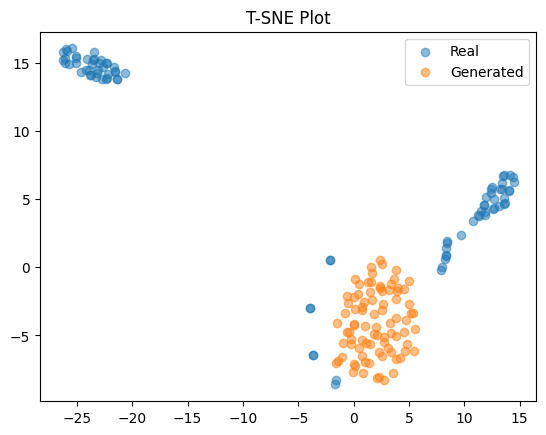

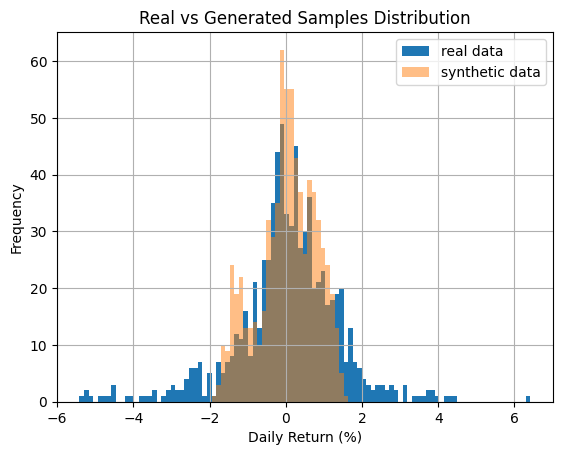

Epoch: 500 Loss D.: 0.407958984375
Epoch: 500 Loss G.: 1.3269219398498535


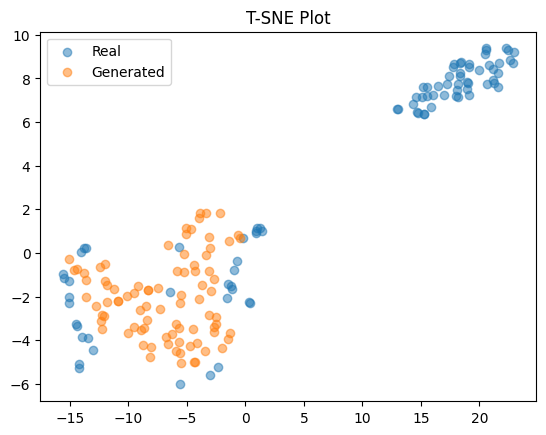

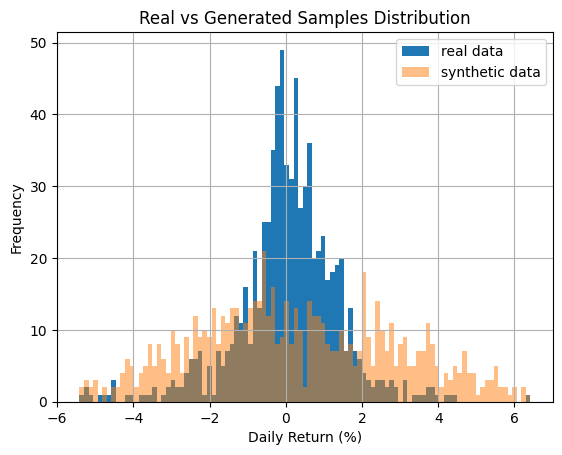

Epoch: 1000 Loss D.: 0.6148689985275269
Epoch: 1000 Loss G.: 0.8403001427650452


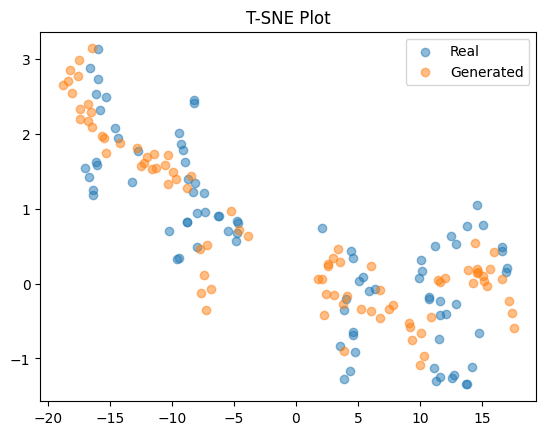

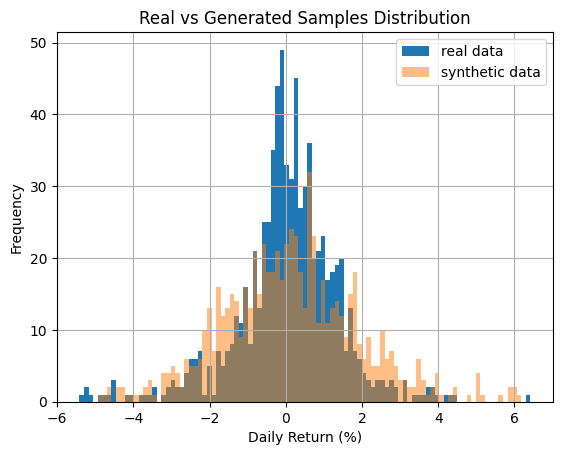

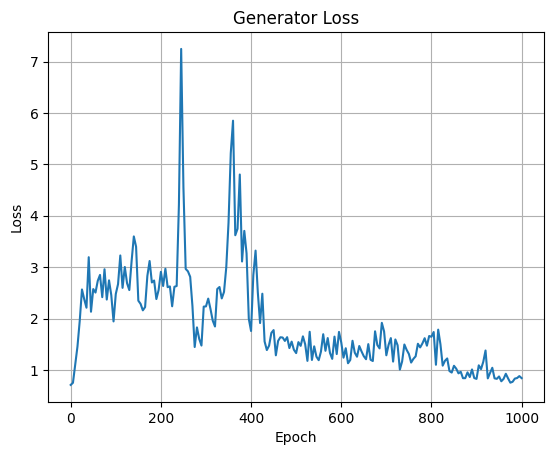

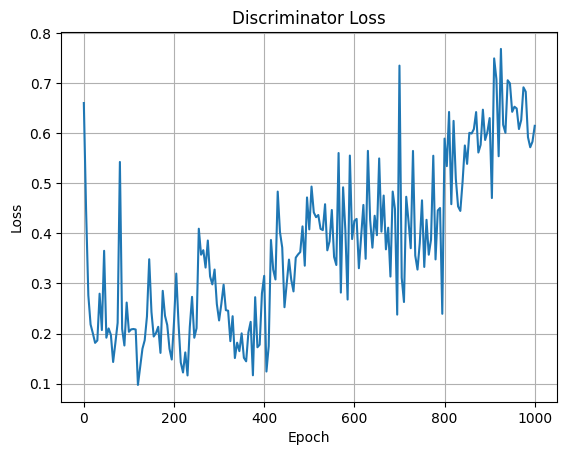

In [35]:
#Train GAN
window_size = 30
latent_dim_GAN = 30
lr = 1e-4
num_epochs = 1001
batch_size = 128
GAN_model = train_GAN(data_train, window_size, latent_dim_GAN, lr, num_epochs, batch_size)

Epoch 0, Loss: 1.1036
25


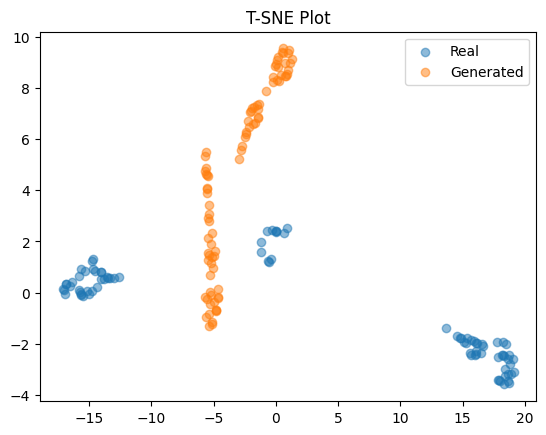

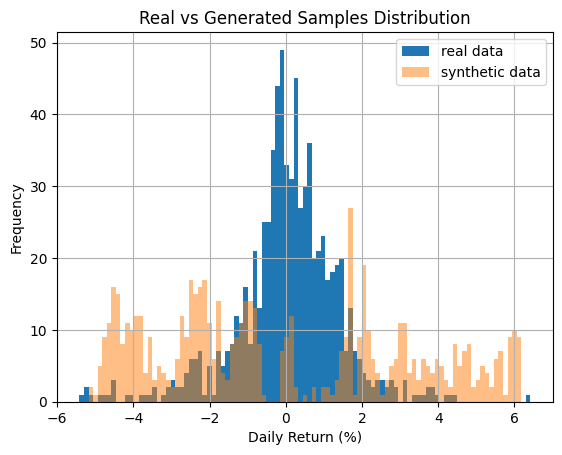

Epoch 500, Loss: 0.0283
25


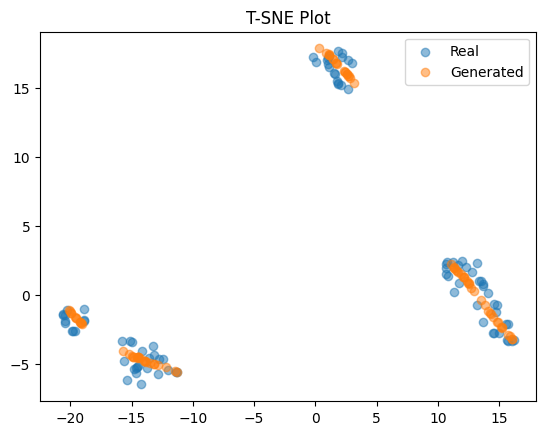

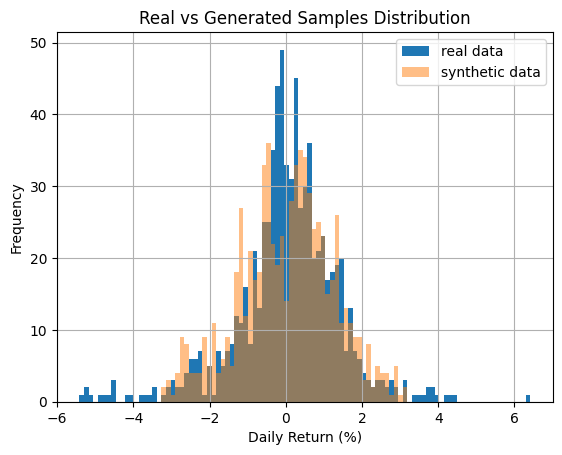

Epoch 1000, Loss: 0.0289
25


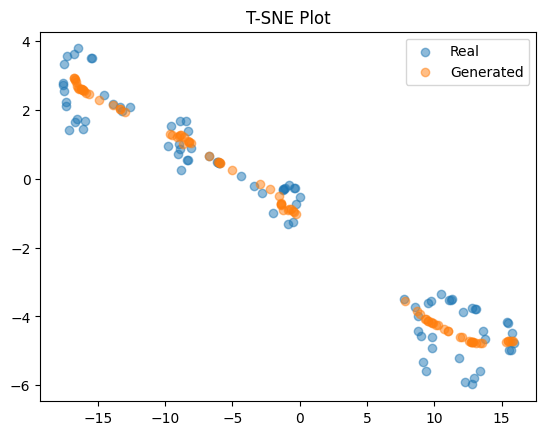

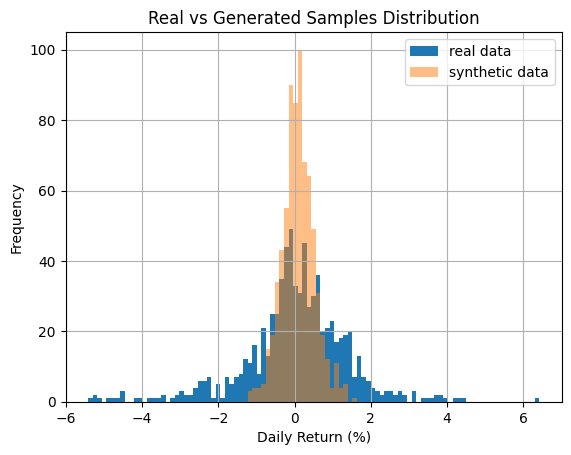

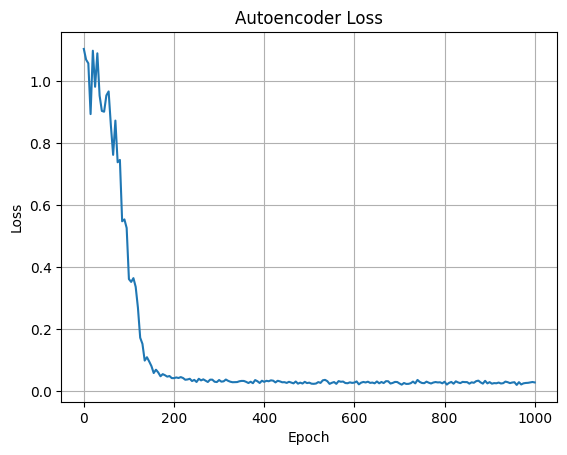

In [21]:
#Train Autoencoder
window_size = 30
latent_dim_AE = 2
lr = 1e-4
num_epochs = 1001
batch_size = 128
AE_model = train_AE(data_train, window_size, latent_dim_AE, lr, num_epochs, batch_size)

Epoch 0, Loss: 3007.1948
25


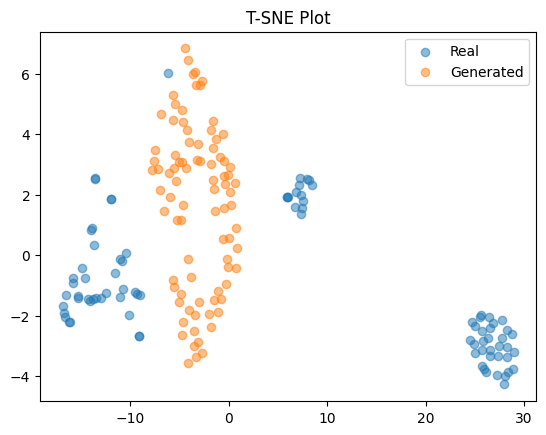

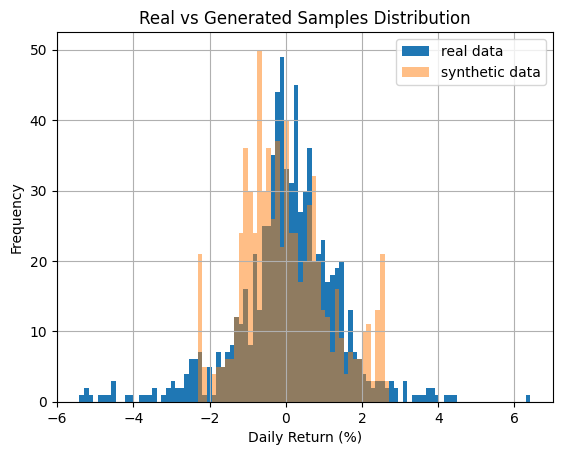

(25, 30)
Epoch 500, Loss: 1617.6562
25


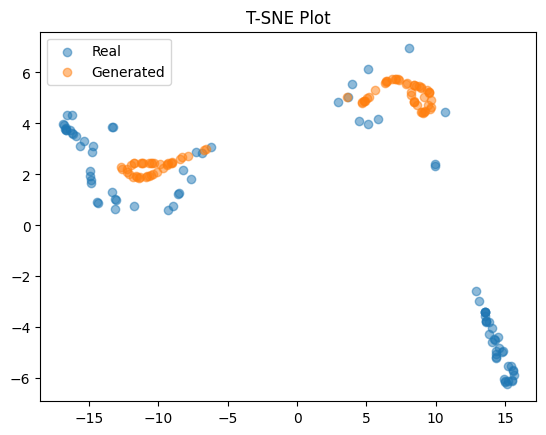

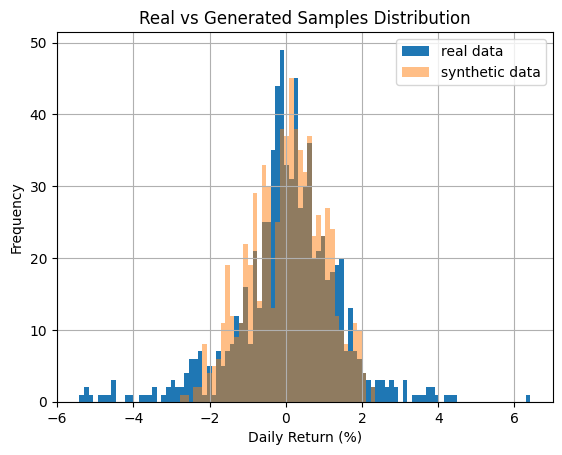

(25, 30)
Epoch 1000, Loss: 1583.7695
25


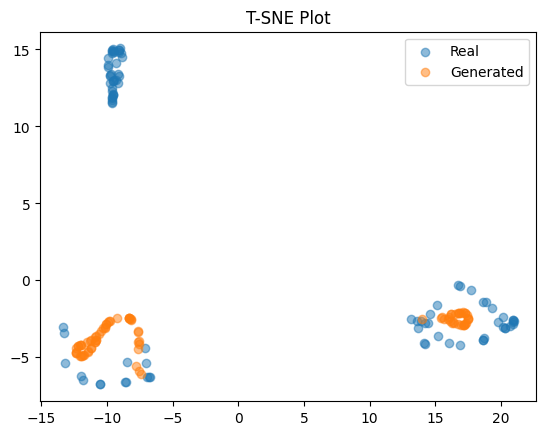

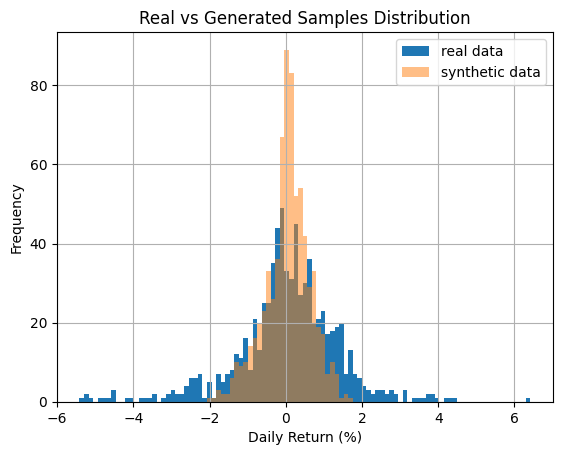

(25, 30)


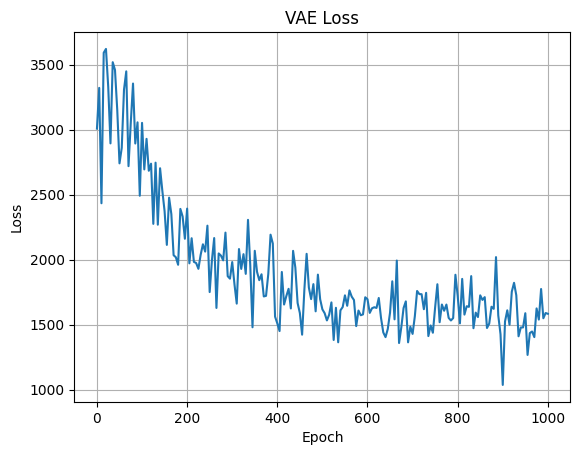

In [26]:
#Train VAE
window_size = 30
latent_dim_VAE = 2
lr = 1e-4
num_epochs = 1001
batch_size = 128
VAE_model = train_VAE(data_train, window_size, latent_dim_AE, lr, num_epochs, batch_size)

In [45]:
#Generate synthetic data
#Real data
data_train_real = sliding_window(data_train, window_size)
alpha = 1 # proportion of synthetic data
num_synthetic = int(alpha*len(data_train_real))

#GAN
data_GAN = GAN_model.generate(num_synthetic, window_size, latent_dim_GAN)
data_train_GAN = np.concatenate((data_train_real, data_GAN), axis=0)

#Autoencoder
data_AE = AE_model.generate(num_synthetic, window_size, latent_dim_AE)
data_train_AE = np.concatenate((data_train_real, data_AE), axis=0)

#VAE
data_VAE = VAE_model.generate(num_synthetic, window_size, latent_dim_VAE)
data_train_VAE = np.concatenate((data_train_real, data_VAE), axis=0)

# Evalutaion using AR model
data_test = np.array(data.iloc[train_index-window_size+1:]['Close'])
data_test_window = sliding_window(data_test, window_size)
X_test = data_test_window[:, :-1] 
y_test = data_test_window[:, -1]
prediction = pd.DataFrame(y_test, columns=['Actual'])

AR_model_real = train_AR(data_train_real)
prediction['AR Real'] = predict_AR(AR_model_real, X_test)

AR_model_GAN = train_AR(data_train_GAN)
prediction['AR GAN'] = predict_AR(AR_model_GAN, X_test)

AR_model_AE = train_AR(data_train_AE)
prediction['AR AE'] = predict_AR(AR_model_AE, X_test)

AR_model_VAE = train_AR(data_train_VAE)
prediction['AR VAE'] = predict_AR(AR_model_VAE, X_test)

MSE = calculate_MSE(prediction)
print(MSE)

[4.28286746 4.54215668 4.29242546 4.33298862]
